# Análise de Dados SRAG (2019-2025)
- Alunos:
  - Andrey Gabriel Ferreira Gonçalves
  - Julia Peghini Vilela Borges
  - Jaqueline Nobre da Silva


**Objetivo:** Carregar os dados brutos, consolidar os arquivos anuais e realizar uma análise diagnóstica para identificar a qualidade dos dados (nulos, ignorados, viés de seleção) focando na predição de gravidade (Internação/UTI).

In [7]:
# Garantir que scikit-learn esteja instalado (resolve erro de importação)
%pip install scikit-learn --quiet

# Célula destinada a armazenar as importações de bibliotecas
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
# Bibliotecas para pre-processamento e modelagem
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


Note: you may need to restart the kernel to use updated packages.


## Variáveis escolhidas:
- Variáveis *target* (alvo):
  - **UTI:** Foi internado em UTI? (1-Sim, 2-Não, 9-Ignorado).
- **Fatores de Risco / Comorbidades:**
    - CARDIOPATI: Doença Cardiovascular Crônica.
    - HEMATOLOGI: Doença Hematológica Crônica.
    - SIND_DOWN: Síndrome de Down.
    - HEPATICA: Doença Hepática Crônica.
    - ASMA: Asma.
    - DIABETES: Diabetes mellitus.
    - NEUROLOGIC: Doença Neurológica Crônica.
    - PNEUMOPATI: Outra Pneumopatia Crônica.
    - IMUNODEPRE: Imunodeficiência ou Imunodepressão.
    - RENAL: Doença Renal Crônica.
    - OBESIDADE: Obesidade.

- **Variável de controle:**
    - **NU_IDADE_N:** Idade do paciente.

In [8]:
# --- 1. CONFIGURAÇÃO DE ARQUIVOS E DIRETÓRIOS ---

# Caminho para a pasta onde os CSVs estão salvos
path_base = './dados'

# Configuração de Estilo dos Gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Lista exata dos arquivos a serem carregados
arquivos = [
    'INFLUD19-26-06-2025.csv',
    'INFLUD20-26-06-2025.csv',
    'INFLUD21-26-06-2025.csv',
    'INFLUD22-26-06-2025.csv',
    'INFLUD23-26-06-2025.csv',
    'INFLUD24-26-06-2025.csv',
    'INFLUD25-24-11-2025.csv'
]

# Definição das colunas estritamente necessárias
colunas_alvo = [
    'DT_NOTIFIC', # Referência temporal
    'HOSPITAL',   # Alvo 1 (Internação)
    'UTI',        # Alvo 2 (Admissão em UTI)
    'NU_IDADE_N', # Variável de Controle (Valor numérico da idade)
    'TP_IDADE',   # Variável de Controle (Unidade da idade: 1-Dia, 2-Mês, 3-Ano)

    # --- Fatores de Risco / Comorbidades ---
    'CARDIOPATI', 'HEMATOLOGI', 'SIND_DOWN', 'HEPATICA', 'ASMA',
    'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE',
    'RENAL', 'OBESIDADE'
]

print("Configuração concluída. Preparando para leitura...")

Configuração concluída. Preparando para leitura...


In [9]:
# --- 2. LEITURA E CONCATENAÇÃO DOS DADOS ---

dfs = []
print("--- Iniciando carregamento dos arquivos ---")

for arquivo in arquivos:
    caminho_completo = os.path.join(path_base, arquivo)

    if os.path.exists(caminho_completo):
        try:
            # Utilizando engine='python' e on_bad_lines='skip' para robustez
            df_temp = pd.read_csv(
                caminho_completo,
                sep=';',
                encoding='ISO-8859-1',
                engine='python',
                on_bad_lines='skip',
                usecols=lambda c: c in colunas_alvo
            )

            # Feedback visual do carregamento
            print(f"[OK] {arquivo}: Carregado com {df_temp.shape[0]} linhas.")
            dfs.append(df_temp)

        except Exception as e:
            print(f"[ERRO] Falha ao ler {arquivo}: {e}")
    else:
        print(f"[AVISO] Arquivo não encontrado no caminho: {caminho_completo}")

# Unificação dos DataFrames
if dfs:
    df_final = pd.concat(dfs, ignore_index=True)
    print(f"\n--- SUCESSO ---")
    print(f"Total de pacientes carregados: {df_final.shape[0]}")
else:
    df_final = pd.DataFrame() # Cria vazio para evitar erro
    print("\n[CRÍTICO] Nenhum dado foi carregado. Verifique o caminho da pasta './dados'.")

--- Iniciando carregamento dos arquivos ---
[OK] INFLUD19-26-06-2025.csv: Carregado com 48961 linhas.
[OK] INFLUD20-26-06-2025.csv: Carregado com 1206920 linhas.
[ERRO] Falha ao ler INFLUD21-26-06-2025.csv: Unable to allocate 13.3 MiB for an array with shape (1745672,) and data type uint64
[OK] INFLUD22-26-06-2025.csv: Carregado com 560577 linhas.
[OK] INFLUD23-26-06-2025.csv: Carregado com 279453 linhas.
[OK] INFLUD24-26-06-2025.csv: Carregado com 267984 linhas.
[OK] INFLUD25-24-11-2025.csv: Carregado com 304062 linhas.

--- SUCESSO ---
Total de pacientes carregados: 2667957


In [10]:
# --- 3. PRÉ-PROCESSAMENTO E DEFINIÇÃO DO TARGET (UTI) ---

if not df_final.empty:
    print("--- 3.1 Otimização e Conversão de Tipos ---")
    # Colunas que devem ser numéricas
    cols_numericas = ['HOSPITAL', 'UTI', 'NU_IDADE_N', 'TP_IDADE']
    
    # Conversão otimizada e tratamento de erros
    for col in cols_numericas:
        df_final[col] = pd.to_numeric(df_final[col], errors='coerce')
    
    # Otimização de memória (Downcasting) - Importante para 4M+ linhas
    # Converte float64 para float32 ou int onde possível
    for col in df_final.select_dtypes(include=['float', 'int']).columns:
        df_final[col] = pd.to_numeric(df_final[col], downcast='integer')
        
    print("Tipagem corrigida e memória otimizada.")

    # --- 3.2 FILTRAGEM DE ESCOPO ---
    total_geral = len(df_final)
    # Filtrar apenas Hospitalizados (HOSPITAL == 1)
    df_final = df_final[df_final['HOSPITAL'] == 1].copy()
    
    print(f"\n--- 3.2 Filtragem de Pacientes ---")
    print(f"Total de Notificações: {total_geral:,.0f}")
    print(f"Pacientes Hospitalizados (Escopo): {len(df_final):,.0f} ({(len(df_final)/total_geral):.1%})")

    # --- 3.3 DEFINIÇÃO DO TARGET ---
    # Analisar como a variável UTI vem preenchida originalmente
    print("\n--- 3.3 Definição do Target (ALVO_GRAVIDADE) ---")
    print("Distribuição original da coluna 'UTI' (1=Sim, 2=Não, 9=Ignorado, NaN=Vazio):")
    print(df_final['UTI'].value_counts(dropna=False).sort_index())

    # Criação do Target Binário:
    # 1 -> 1 (UTI)
    # Qualquer outra coisa (2, 9, NaN) -> 0 (Não UTI/Enfermaria)
    df_final['ALVO_GRAVIDADE'] = np.where(df_final['UTI'] == 1, 1, 0)
    
    print(f"\nTarget criado. Distribuição final:")
    print(df_final['ALVO_GRAVIDADE'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

else:
    print("DataFrame vazio. Verifique o carregamento.")

--- 3.1 Otimização e Conversão de Tipos ---
Tipagem corrigida e memória otimizada.

--- 3.2 Filtragem de Pacientes ---
Total de Notificações: 2,667,957
Pacientes Hospitalizados (Escopo): 2,527,572 (94.7%)

--- 3.3 Definição do Target (ALVO_GRAVIDADE) ---
Distribuição original da coluna 'UTI' (1=Sim, 2=Não, 9=Ignorado, NaN=Vazio):
UTI
1.0     737635
2.0    1530713
9.0      44020
NaN     215204
Name: count, dtype: int64

Target criado. Distribuição final:
ALVO_GRAVIDADE
0    70.82%
1    29.18%
Name: proportion, dtype: object


In [11]:
# --- 4. ANÁLISE DE SAÚDE DOS DADOS (Data Quality) ---

if not df_final.empty:
    # Como filtramos a base no passo anterior, df_analise é o próprio df_final
    df_analise = df_final

    print("=== 4.1 Qualidade das Variáveis Explicativas (Comorbidades) ===")
    
    comorbidades = [
        'CARDIOPATI', 'HEMATOLOGI', 'SIND_DOWN', 'HEPATICA', 'ASMA',
        'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE',
        'RENAL', 'OBESIDADE'
    ]

    # Construção de um Relatório de Qualidade Tabular
    dados_qualidade = []
    total = len(df_analise)

    for col in comorbidades:
        counts = df_analise[col].value_counts(dropna=False)
        
        nulos = counts.get(np.nan, 0)
        ignorados = counts.get(9, 0)  # Código 9 = Ignorado
        sim = counts.get(1, 0)
        nao = counts.get(2, 0)
        
        # Qualidade: O quanto a variável é 'confiável' (Preenchida com Sim ou Não)
        preenchimento_valido = sim + nao
        ruido = nulos + ignorados

        dados_qualidade.append({
            'Variável': col,
            '% Sim (1)': (sim / total) * 100,
            '% Não (2)': (nao / total) * 100,
            '% Ignorado (9)': (ignorados / total) * 100,
            '% Nulo (NaN)': (nulos / total) * 100,
            '% Ruído Total': (ruido / total) * 100
        })

    df_qualidade = pd.DataFrame(dados_qualidade).set_index('Variável')
    df_qualidade = df_qualidade.sort_values('% Ruído Total', ascending=False)

    # Exibição formatada
    print("Tabela de Integridade das Comorbidades (Ordenada por Ruído):")
    pd.options.display.float_format = '{:.2f}%'.format
    display(df_qualidade)
    pd.options.display.float_format = None

    print("\n=== 4.2 Correlação Preliminar: Idade vs Target ===")
    corr_idade = df_analise['NU_IDADE_N'].corr(df_analise['ALVO_GRAVIDADE'])
    print(f"Correlação de Pearson (Idade <-> Admissão UTI): {corr_idade:.4f}")
    if corr_idade > 0:
        print("-> Correlação Positiva: Quanto maior a idade, maior a chance de UTI.")
    else:
        print("-> Correlação Negativa/Nula.")

else:
    print("DataFrame vazio.")

=== 4.1 Qualidade das Variáveis Explicativas (Comorbidades) ===
Tabela de Integridade das Comorbidades (Ordenada por Ruído):


,% Sim (1),% Não (2),% Ignorado (9),% Nulo (NaN),% Ruído Total
Variável,,,,,
HEPATICA,0.86%,34.95%,0.79%,63.40%,64.19%
SIND_DOWN,0.52%,35.38%,0.71%,63.39%,64.10%
HEMATOLOGI,0.97%,34.98%,0.80%,63.25%,64.05%
OBESIDADE,3.70%,32.38%,1.07%,62.85%,63.91%
IMUNODEPRE,3.18%,33.33%,0.78%,62.72%,63.49%
RENAL,3.56%,33.05%,0.73%,62.66%,63.39%
ASMA,5.00%,32.11%,0.74%,62.15%,62.88%
PNEUMOPATI,5.38%,31.76%,0.76%,62.09%,62.85%
NEUROLOGIC,5.11%,32.08%,0.73%,62.08%,62.81%



=== 4.2 Correlação Preliminar: Idade vs Target ===
Correlação de Pearson (Idade <-> Admissão UTI): 0.0854
-> Correlação Positiva: Quanto maior a idade, maior a chance de UTI.


## Análise inicial da saúde dos dados
- Problemas identificados:
  - Todas as colunas de comorbidade possuem uma alta porcentagem de nulos, sendo 56% a menor e 65.32% a maior.

## Investigação de Viés Temporal e Limitações

Além dos nulos, investigamos se há distorções causadas pelo fator **tempo** (anos de pandemia vs. anos normais) e limitações na definição do target.

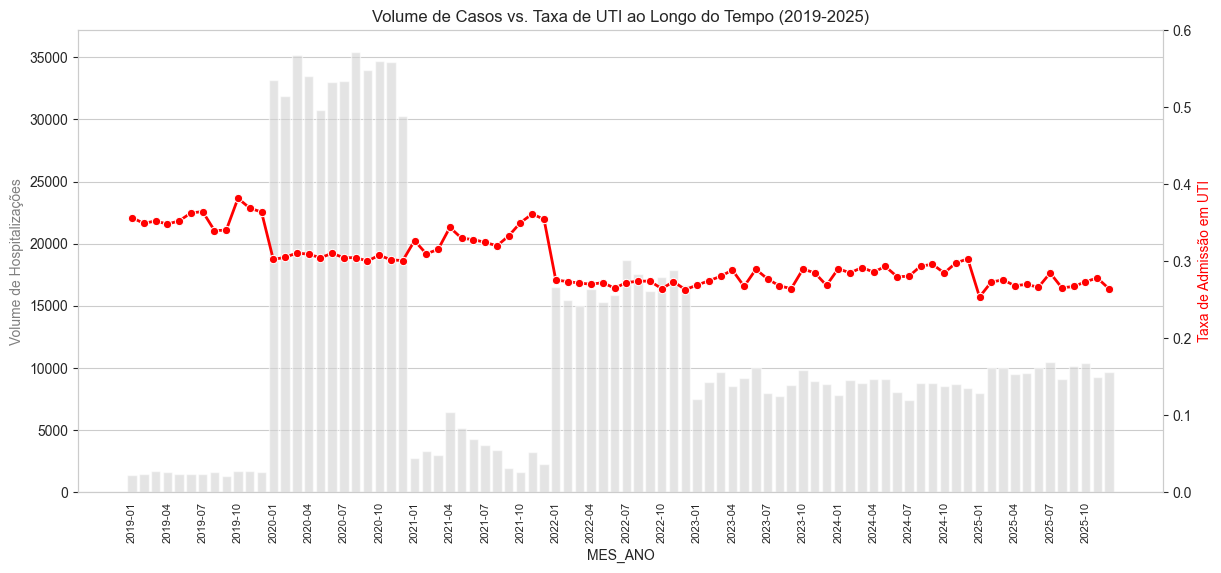

In [12]:
# --- 9.1 ANÁLISE TEMPORAL (Sazonalidade e Pandemia) ---

# Garantir que df_analise é uma cópia independente para evitar SettingWithCopyWarning
df_analise = df_analise.copy()

# Converter Data de Notificação
df_analise['DT_NOTIFIC'] = pd.to_datetime(df_analise['DT_NOTIFIC'], dayfirst=True, errors='coerce')

# Criar coluna de Mês/Ano para agrupamento
df_analise['MES_ANO'] = df_analise['DT_NOTIFIC'].dt.to_period('M')

# Agrupar dados por mês
resumo_temporal = df_analise.groupby('MES_ANO').agg(
    total_casos=('HOSPITAL', 'count'),
    taxa_uti=('ALVO_GRAVIDADE', 'mean')
).reset_index()

# Converter period para timestamp para plotagem
resumo_temporal['MES_ANO_DT'] = resumo_temporal['MES_ANO'].dt.to_timestamp()

# PLOTAGEM
fig, ax1 = plt.subplots(figsize=(14, 6))

# Eixo 1: Volume de Casos (Barras)
sns.barplot(data=resumo_temporal, x='MES_ANO', y='total_casos', color='lightgray', alpha=0.6, ax=ax1)
ax1.set_ylabel('Volume de Hospitalizações', color='gray')
ax1.tick_params(axis='x', rotation=90, labelsize=8)
# Reduzir a quantidade de labels no eixo X para não poluir
for index, label in enumerate(ax1.get_xticklabels()):
    if index % 3 != 0:
        label.set_visible(False)

# Eixo 2: Taxa de UTI (Linha)
ax2 = ax1.twinx()
sns.lineplot(data=resumo_temporal, x=resumo_temporal.index, y='taxa_uti', color='red', marker='o', ax=ax2, linewidth=2)
ax2.set_ylabel('Taxa de Admissão em UTI', color='red')
ax2.set_ylim(0, 0.6) # Escala fixa para visualizar melhor a variação

plt.title('Volume de Casos vs. Taxa de UTI ao Longo do Tempo (2019-2025)')
plt.grid(False)
plt.show()

### Diagnóstico de Problemas Estruturais

1.  **Viés de "Onda" (Temporal):**
    *   O gráfico acima mostra picos claros de volume (Ondas COVID).
    *   Observe a linha vermelha (Taxa UTI): Se ela flutuar drasticamente (ex: cair quando o volume sobe muito), pode indicar **colapso do sistema** (gente precisando de UTI mas não conseguindo vaga), o que "suja" o target.

2.  **O Problema da "Morte Invisível" (Limitação do Target):**
    *   Atualmente definimos `Gravidade = UTI`.
    *   **Risco Crítico:** Pacientes que faleceram na enfermaria ou na emergência *sem* ir para UTI estão sendo classificados como `Target 0` (Não Graves). Isso ensina o modelo errado.
    *   **Recomendação:** Futuramente, incluir a coluna `EVOLUCAO` (Alta/Óbito) na carga de dados para criar um target composto (`UTI == 1` OU `EVOLUCAO == Óbito`).

## Tratamento de Dados (Limpeza e Padronização)

Nesta etapa, aplicaremos as seguintes correções:
1. **Comorbidades:** Devido ao alto número de nulos e ignorados (código 9), assumiremos a premissa conservadora: **Se não marcado como Sim (1), consideramos Não (0)**. Isso permite utilizar os dados para modelagem, transformando as variáveis em binárias.
2. **Idade:** Filtragem de valores inconsistentes (menores que 0 ou maiores que 120 anos) e padronização para anos.
3. **Tipagem:** Garantia de tipos inteiros para variáveis categóricas.

In [13]:
# --- 5. TRATAMENTO DE DADOS ---

# 5.1 Tratamento de Comorbidades
# Mapeamento: 1 -> 1 (Sim), {2, 9, NaN} -> 0 (Não)
cols_comorbidades = [
    'CARDIOPATI', 'HEMATOLOGI', 'SIND_DOWN', 'HEPATICA', 'ASMA',
    'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE',
    'RENAL', 'OBESIDADE'
]

for col in cols_comorbidades:
    # Preenche nulos com 0, substitui 2 e 9 por 0, mantém 1 como 1
    df_analise[col] = df_analise[col].fillna(0).replace({2: 0, 9: 0}).astype(int)

print("Comorbidades binarias (0/1) processadas.")

# 5.2 Tratamento de Idade
# Padronizar tudo para ANOS (TP_IDADE: 1=Dia, 2=Mês, 3=Ano)
# Para simplificar, se TP_IDADE for 1 ou 2 (bebês), idade em anos é 0.
df_analise.loc[df_analise['TP_IDADE'].isin([1, 2]), 'NU_IDADE_N'] = 0

# Remover inconsistências (Idade negativa ou > 120)
df_analise = df_analise[(df_analise['NU_IDADE_N'] >= 0) & (df_analise['NU_IDADE_N'] <= 120)]

print(f"Base após limpeza de idade: {len(df_analise)} registros.")

# Verificação final de nulos nas colunas de interesse
print("\nNulos restantes nas colunas-chave:")
print(df_analise[cols_comorbidades + ['NU_IDADE_N', 'ALVO_GRAVIDADE']].isnull().sum())

Comorbidades binarias (0/1) processadas.
Base após limpeza de idade: 2527565 registros.

Nulos restantes nas colunas-chave:
CARDIOPATI        0
HEMATOLOGI        0
SIND_DOWN         0
HEPATICA          0
ASMA              0
DIABETES          0
NEUROLOGIC        0
PNEUMOPATI        0
IMUNODEPRE        0
RENAL             0
OBESIDADE         0
NU_IDADE_N        0
ALVO_GRAVIDADE    0
dtype: int64


## Estatísticas Descritivas
Análise da tendência central e dispersão dos dados tratados.

In [7]:
# Estatísticas da Idade (Geral e por Grupo UTI)
print("--- Estatísticas Descritivas: IDADE ---")
# Melhorando a visualização de números grandes e decimais
pd.options.display.float_format = '{:,.2f}'.format
print(df_analise['NU_IDADE_N'].describe())
pd.options.display.float_format = None # Resetar para o padrão do pandas

print("\n--- Idade Média por Desfecho (UTI) ---")
print(df_analise.groupby('ALVO_GRAVIDADE')['NU_IDADE_N'].agg(['mean', 'median', 'std', 'min', 'max']))

print("\n--- Frequência das Comorbidades (Após Tratamento) ---")
print(df_analise[cols_comorbidades].sum().sort_values(ascending=False))

--- Estatísticas Descritivas: IDADE ---
count   4,191,909.00
mean           48.63
std            28.69
min             0.00
25%            29.00
50%            55.00
75%            71.00
max           120.00
Name: NU_IDADE_N, dtype: float64

--- Idade Média por Desfecho (UTI) ---
                     mean  median        std  min  max
ALVO_GRAVIDADE                                        
0               47.049930    53.0  29.084229    0  120
1               52.355465    59.0  27.358096    0  119

--- Frequência das Comorbidades (Após Tratamento) ---
CARDIOPATI    1111117
DIABETES       750597
OBESIDADE      227280
PNEUMOPATI     189256
NEUROLOGIC     183629
ASMA           177674
RENAL          136270
IMUNODEPRE     115212
HEMATOLOGI      34623
HEPATICA        33422
SIND_DOWN       18091
dtype: int64


## Análise Visual e Gráfica
Visualização da distribuição de idade e impacto das comorbidades na admissão em UTI.

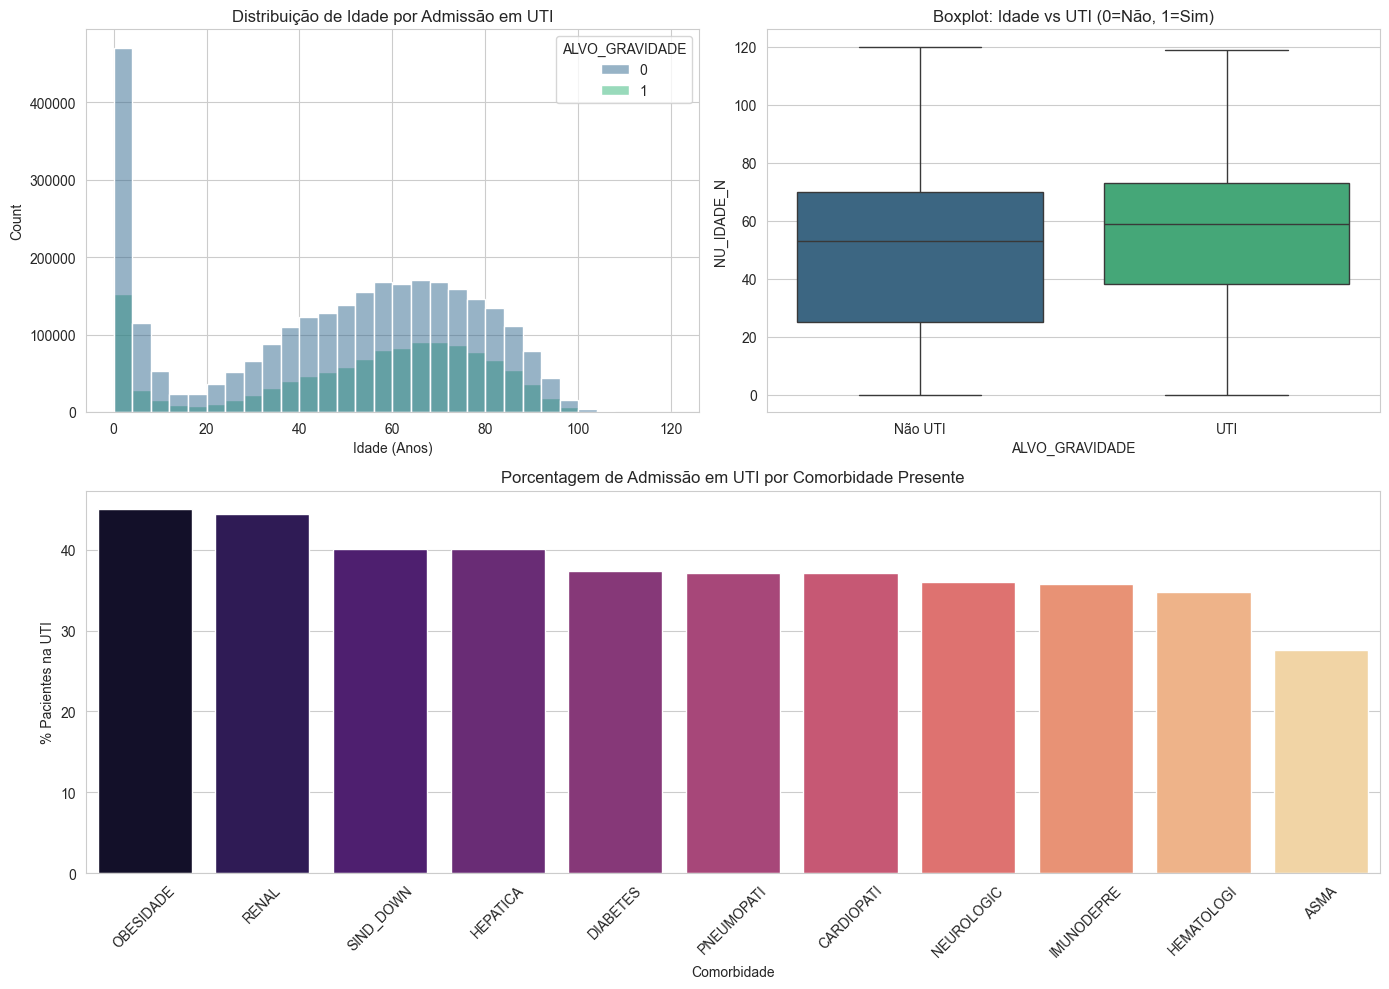

In [8]:
# Configurações visuais
plt.figure(figsize=(14, 10))

# 1. Histograma de Idade por UTI
plt.subplot(2, 2, 1)
# Removido kde=True para evitar erros de overflow em grandes volumes de dados e melhorar performance
sns.histplot(data=df_analise, x='NU_IDADE_N', hue='ALVO_GRAVIDADE', bins=30, palette='viridis')
plt.title('Distribuição de Idade por Admissão em UTI')
plt.xlabel('Idade (Anos)')

# 2. Boxplot de Idade vs UTI
plt.subplot(2, 2, 2)
# Ajuste para evitar FutureWarning: palette sem hue
sns.boxplot(x='ALVO_GRAVIDADE', y='NU_IDADE_N', hue='ALVO_GRAVIDADE', data=df_analise, palette='viridis', legend=False)
plt.title('Boxplot: Idade vs UTI (0=Não, 1=Sim)')
plt.xticks([0, 1], ['Não UTI', 'UTI'])

# 3. Comparação de Comorbidades (Percentual de UTI)
# Calculando % de UTI para quem tem cada doença
risco_comorbidade = []
for col in cols_comorbidades:
    # Filtra apenas quem tem a doença
    pacientes_com_doenca = df_analise[df_analise[col] == 1]
    if len(pacientes_com_doenca) > 0:
        taxa_uti = pacientes_com_doenca['ALVO_GRAVIDADE'].mean() * 100
        risco_comorbidade.append({'Comorbidade': col, '% UTI': taxa_uti})

df_risco = pd.DataFrame(risco_comorbidade).sort_values('% UTI', ascending=False)

plt.subplot(2, 1, 2)
# Ajuste para evitar FutureWarning: palette sem hue
sns.barplot(x='Comorbidade', y='% UTI', hue='Comorbidade', data=df_risco, palette='magma', legend=False)
plt.title('Porcentagem de Admissão em UTI por Comorbidade Presente')
plt.ylabel('% Pacientes na UTI')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Reflexões e Próximos Passos

**Observações:**
- A distribuição de idade mostra que pacientes mais idosos têm maior tendência a serem admitidos na UTI.
- Algumas comorbidades (como OBESIDADE e RENAL) parecem apresentar taxas proporcionalmente maiores de admissão em UTI em relação a outras, o que sugere alto poder preditivo.
- O tratamento dos nulos (assumindo 0) permitiu recuperar a base completa, mas introduz um viés conservador.

**Próximos Passos:**
- Testar modelos de Machine Learning (Regressão Logística, Random Forest) usando 'ALVO_GRAVIDADE' como target.
- Avaliar balanceamento de classes (SMOTE se necessário, embora a proporção ~30% seja aceitável).

##   Feature Engineering (Engenharia de Atributos)

A etapa de engenharia de atributos foi realizada para preparar os dados antes da modelagem com Regressão Logística. Todas as escolhas abaixo foram feitas para garantir consistência, equilíbrio e correção estatística no processo de treinamento.

### 1. Seleção de Features e Target

Foram selecionadas como features a idade (NU_IDADE_N) e todas as comorbidades já tratadas como variáveis binárias (0/1).
Essas variáveis foram escolhidas porque representam fatores de risco diretamente associados à gravidade clínica, sendo essenciais para estimar a probabilidade de um paciente ser admitido em UTI.

O target definido foi ALVO_GRAVIDADE (0 = Não UTI, 1 = UTI), pois representa o desfecho central a ser previsto pelo modelo.
Essa seleção é coerente nesse caso e garante que o modelo trabalhe com variáveis clinicamente relevantes e já padronizadas.

### 2. Divisão em Treino e Teste (70% / 30%)

A base foi dividida em 70% para treino e 30% para teste, com uso de stratify=y.
Essa escolha possui três justificativas principais:

    a) 70% para Treino — aprender padrões

Essa proporção fornece ao modelo uma quantidade suficiente de dados para aprender as relações entre idade, comorbidades e gravidade, aumentando a estabilidade dos coeficientes da Regressão Logística.

    b) 30% para Teste — avaliação robusta

Destinar 30% para teste cria um conjunto amplo o bastante para obter uma avaliação estatisticamente confiável, especialmente útil em bases de saúde onde:
podem existir classes desbalanceadas, é importante medir a sensibilidade (recall) com precisão, a generalização deve ser bem verificada.

    c) Uso de stratify=y

Foi utilizado para manter a mesma proporção de casos UTI/não UTI nos conjuntos de treino e teste.
Isso impede distorções como:

- treino com poucos casos graves, teste com distribuição artificialmente diferente da real. Portanto, a divisão 70/30 estratificada garante treinamento consistente e avaliação justa da capacidade do modelo.

### 3. Padronização da Idade (Standardization)

A variável NU_IDADE_N foi padronizada (média 0 e desvio padrão 1) porque:

- A Regressão Logística é sensível à escala, e a idade tem magnitude muito maior que comorbidades binárias.

- A padronização evita que a idade domine o cálculo dos coeficientes.

- Melhora a convergência do modelo e a estabilidade numérica durante o treinamento.

- A padronização foi aplicada corretamente apenas aos dados de treino (fit_transform), e depois replicada aos dados de teste (transform) para evitar data leakage, garantindo que o modelo não receba informação indevida sobre o conjunto de teste.

- As comorbidades não foram padronizadas porque já estão em escala adequada (0/1).

In [14]:
# --- 6. FEATURE ENGINEERING PARA MODELAGEM ---

# Em algumas execuções o kernel pode ter sido reiniciado e a variável
# 'cols_comorbidades' pode não existir. Criamos um fallback sem sobrescrever
# se já estiver definida.
if 'cols_comorbidades' not in globals():
    cols_comorbidades = [
        'CARDIOPATI', 'HEMATOLOGI', 'SIND_DOWN', 'HEPATICA', 'ASMA',
        'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE',
        'RENAL', 'OBESIDADE'
    ]

# Garantir que df_analise exista; tentar reconstruir a partir de df_final se possível
if 'df_analise' not in globals():
    # 1) Se df_final existir e não estiver vazio, reconstruir a partir dele
    if 'df_final' in globals() and not df_final.empty:
        df_analise = df_final.copy()
    else:
        # 2) Tentar reconstruir df_final a partir dos arquivos originais, se as variáveis estiverem disponíveis
        if 'path_base' in globals() and 'arquivos' in globals() and 'colunas_alvo' in globals():
            dfs_recon = []
            print("Tentando reconstruir df_final lendo os arquivos em 'arquivos' ...")
            for arquivo in arquivos:
                caminho_completo = os.path.join(path_base, arquivo)
                if os.path.exists(caminho_completo):
                    try:
                        df_temp = pd.read_csv(
                            caminho_completo,
                            sep=';',
                            encoding='ISO-8859-1',
                            engine='python',
                            on_bad_lines='skip',
                            usecols=lambda c: c in colunas_alvo
                        )
                        dfs_recon.append(df_temp)
                        print(f"[OK] {arquivo}: {df_temp.shape[0]} linhas lidas.")
                    except Exception as e:
                        print(f"[ERRO] Falha ao ler {arquivo}: {e}")
                else:
                    print(f"[AVISO] Arquivo não encontrado: {caminho_completo}")
            if dfs_recon:
                df_final = pd.concat(dfs_recon, ignore_index=True)
                print(f"Reconstruído df_final com {len(df_final)} registros.")
                df_analise = df_final.copy()
            else:
                raise NameError("df_final não encontrado e não foi possível carregar arquivos para reconstruir. Execute as células de leitura/carregamento anteriores.")
        else:
            raise NameError("df_analise não está definido e não foi possível reconstruí-lo: variáveis df_final ou arquivos indisponíveis. Execute as células de carregamento/pré-processamento (ex.: leitura e tratamento) antes desta etapa.")

    # A partir daqui temos df_analise (cópia de df_final). Aplicar os passos essenciais de pré-processamento
    # Verificar colunas necessárias
    cols_needed = ['NU_IDADE_N', 'HOSPITAL', 'UTI', 'TP_IDADE'] + cols_comorbidades
    missing = [c for c in cols_needed if c not in df_analise.columns]
    if missing:
        raise NameError(f"Não foi possível reconstruir df_analise: faltam colunas em df_analise: {missing}. Execute as células de pré-processamento anteriores.")
    # Conversão de tipos essenciais
    for col in ['HOSPITAL', 'UTI', 'NU_IDADE_N', 'TP_IDADE']:
        df_analise[col] = pd.to_numeric(df_analise[col], errors='coerce')
    # Filtrar apenas hospitalizados (mesma lógica das células anteriores)
    df_analise = df_analise[df_analise['HOSPITAL'] == 1].copy()
    # Criar ALVO_GRAVIDADE se necessário
    if 'ALVO_GRAVIDADE' not in df_analise.columns:
        df_analise['ALVO_GRAVIDADE'] = np.where(df_analise['UTI'] == 1, 1, 0)
    # Tratar comorbidades como binárias (sem sobrescrever se já estiverem corretas)
    for col in cols_comorbidades:
        if col in df_analise.columns:
            df_analise[col] = df_analise[col].fillna(0).replace({2: 0, 9: 0}).astype(int)
    # Padronizar idade (TP_IDADE: 1=Dia, 2=Mês -> idade = 0)
    if 'TP_IDADE' in df_analise.columns and 'NU_IDADE_N' in df_analise.columns:
        df_analise.loc[df_analise['TP_IDADE'].isin([1, 2]), 'NU_IDADE_N'] = 0
        df_analise = df_analise[(df_analise['NU_IDADE_N'] >= 0) & (df_analise['NU_IDADE_N'] <= 120)]

# 6.1 Seleção de Features e Target
# Features (X): Idade e todas as comorbidades já tratadas (0/1)
# Target (y): ALVO_GRAVIDADE (0 para Não-UTI, 1 para UTI)
features = ['NU_IDADE_N'] + cols_comorbidades
target = 'ALVO_GRAVIDADE'

# Verificar existência das colunas selecionadas
missing_feat = [c for c in features + [target] if c not in df_analise.columns]
if missing_feat:
    raise NameError(f"As seguintes colunas necessárias não existem em df_analise: {missing_feat}. Verifique o pré-processamento.")

X = df_analise[features]
y = df_analise[target]

# 6.2 Divisão em Treino e Teste
# Usamos stratify=y para garantir que a proporção de casos graves/não graves
# seja a mesma nos conjuntos de treino e teste.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3,  # 30% dos dados para teste
    random_state=42,
    stratify=y
)

# 6.3 Padronização da Idade (Standardization)
# A padronização é crucial para modelos como Regressão Logística.
# Usamos o scaler treinado APENAS nos dados de treino para evitar data leakage.
scaler = StandardScaler()

# Ajusta o scaler aos dados de treino e os transforma
X_train_scaled = X_train.copy()
X_train_scaled['NU_IDADE_N'] = scaler.fit_transform(X_train_scaled[['NU_IDADE_N']])

# Transforma os dados de teste com o scaler JÁ TREINADO
X_test_scaled = X_test.copy()
X_test_scaled['NU_IDADE_N'] = scaler.transform(X_test_scaled[['NU_IDADE_N']])

print("--- Feature Engineering Concluído ---")
print(f"Formato de X_train: {X_train.shape}")
print(f"Formato de X_test: {X_test.shape}")
print("\nPrimeiras 5 linhas dos dados de treino padronizados (X_train_scaled):")
print(X_train_scaled.head())

# Em algumas execuções o kernel pode ter sido reiniciado e a variável
# 'cols_comorbidades' pode não existir. Criamos um fallback sem sobrescrever
# se já estiver definida.
if 'cols_comorbidades' not in globals():
    cols_comorbidades = [
        'CARDIOPATI', 'HEMATOLOGI', 'SIND_DOWN', 'HEPATICA', 'ASMA',
        'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE',
        'RENAL', 'OBESIDADE'
    ]

# Garantir que df_analise exista; tentar reconstruir a partir de df_final se possível
if 'df_analise' not in globals():
    # 1) Se df_final existir e não estiver vazio, reconstruir a partir dele
    if 'df_final' in globals() and not df_final.empty:
        df_analise = df_final.copy()
    else:
        # 2) Tentar reconstruir df_final a partir dos arquivos originais, se as variáveis estiverem disponíveis
        if 'path_base' in globals() and 'arquivos' in globals() and 'colunas_alvo' in globals():
            dfs_recon = []
            print("Tentando reconstruir df_final lendo os arquivos em 'arquivos' ...")
            for arquivo in arquivos:
                caminho_completo = os.path.join(path_base, arquivo)
                if os.path.exists(caminho_completo):
                    try:
                        df_temp = pd.read_csv(
                            caminho_completo,
                            sep=';',
                            encoding='ISO-8859-1',
                            engine='python',
                            on_bad_lines='skip',
                            usecols=lambda c: c in colunas_alvo
                        )
                        dfs_recon.append(df_temp)
                        print(f"[OK] {arquivo}: {df_temp.shape[0]} linhas lidas.")
                    except Exception as e:
                        print(f"[ERRO] Falha ao ler {arquivo}: {e}")
                else:
                    print(f"[AVISO] Arquivo não encontrado: {caminho_completo}")
            if dfs_recon:
                df_final = pd.concat(dfs_recon, ignore_index=True)
                print(f"Reconstruído df_final com {len(df_final)} registros.")
                df_analise = df_final.copy()
            else:
                raise NameError("df_final não encontrado e não foi possível carregar arquivos para reconstruir. Execute as células de leitura/carregamento anteriores.")
        else:
            raise NameError("df_analise não está definido e não foi possível reconstruí-lo: variáveis df_final ou arquivos indisponíveis. Execute as células de carregamento/pré-processamento (ex.: leitura e tratamento) antes desta etapa.")

    # A partir daqui temos df_analise (cópia de df_final). Aplicar os passos essenciais de pré-processamento
    # Verificar colunas necessárias
    cols_needed = ['NU_IDADE_N', 'HOSPITAL', 'UTI', 'TP_IDADE'] + cols_comorbidades
    missing = [c for c in cols_needed if c not in df_analise.columns]
    if missing:
        raise NameError(f"Não foi possível reconstruir df_analise: faltam colunas em df_analise: {missing}. Execute as células de pré-processamento anteriores.")
    # Conversão de tipos essenciais
    for col in ['HOSPITAL', 'UTI', 'NU_IDADE_N', 'TP_IDADE']:
        df_analise[col] = pd.to_numeric(df_analise[col], errors='coerce')
    # Filtrar apenas hospitalizados (mesma lógica das células anteriores)
    df_analise = df_analise[df_analise['HOSPITAL'] == 1].copy()
    # Criar ALVO_GRAVIDADE se necessário
    if 'ALVO_GRAVIDADE' not in df_analise.columns:
        df_analise['ALVO_GRAVIDADE'] = np.where(df_analise['UTI'] == 1, 1, 0)
    # Tratar comorbidades como binárias (sem sobrescrever se já estiverem corretas)
    for col in cols_comorbidades:
        if col in df_analise.columns:
            df_analise[col] = df_analise[col].fillna(0).replace({2: 0, 9: 0}).astype(int)
    # Padronizar idade (TP_IDADE: 1=Dia, 2=Mês -> idade = 0)
    if 'TP_IDADE' in df_analise.columns and 'NU_IDADE_N' in df_analise.columns:
        df_analise.loc[df_analise['TP_IDADE'].isin([1, 2]), 'NU_IDADE_N'] = 0
        df_analise = df_analise[(df_analise['NU_IDADE_N'] >= 0) & (df_analise['NU_IDADE_N'] <= 120)]

# 6.1 Seleção de Features e Target
# Features (X): Idade e todas as comorbidades já tratadas (0/1)
# Target (y): ALVO_GRAVIDADE (0 para Não-UTI, 1 para UTI)
features = ['NU_IDADE_N'] + cols_comorbidades
target = 'ALVO_GRAVIDADE'

# Verificar existência das colunas selecionadas
missing_feat = [c for c in features + [target] if c not in df_analise.columns]
if missing_feat:
    raise NameError(f"As seguintes colunas necessárias não existem em df_analise: {missing_feat}. Verifique o pré-processamento.")

X = df_analise[features]
y = df_analise[target]

# 6.2 Divisão em Treino e Teste
# Usamos stratify=y para garantir que a proporção de casos graves/não graves
# seja a mesma nos conjuntos de treino e teste.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3,  # 30% dos dados para teste
    random_state=42,
    stratify=y
)

# 6.3 Padronização da Idade (Standardization)
# A padronização é crucial para modelos como Regressão Logística.
# Usamos o scaler treinado APENAS nos dados de treino para evitar data leakage.
scaler = StandardScaler()

# Ajusta o scaler aos dados de treino e os transforma
X_train_scaled = X_train.copy()
X_train_scaled['NU_IDADE_N'] = scaler.fit_transform(X_train_scaled[['NU_IDADE_N']])

# Transforma os dados de teste com o scaler JÁ TREINADO
X_test_scaled = X_test.copy()
X_test_scaled['NU_IDADE_N'] = scaler.transform(X_test_scaled[['NU_IDADE_N']])

print("--- Feature Engineering Concluído ---")
print(f"Formato de X_train: {X_train.shape}")
print(f"Formato de X_test: {X_test.shape}")
print("\nPrimeiras 5 linhas dos dados de treino padronizados (X_train_scaled):")
print(X_train_scaled.head())

--- Feature Engineering Concluído ---
Formato de X_train: (1769295, 12)
Formato de X_test: (758270, 12)

Primeiras 5 linhas dos dados de treino padronizados (X_train_scaled):
         NU_IDADE_N  CARDIOPATI  HEMATOLOGI  SIND_DOWN  HEPATICA  ASMA  \
1540838    0.711288           0           0          0         0     0   
963399     0.237448           0           0          0         0     0   
990732     0.395394           1           0          0         0     0   
2120403   -1.310431           0           0          0         0     1   
865993     0.742877           0           0          0         0     0   

         DIABETES  NEUROLOGIC  PNEUMOPATI  IMUNODEPRE  RENAL  OBESIDADE  
1540838         0           0           0           0      0          0  
963399          0           0           0           0      0          0  
990732          0           1           1           0      0          0  
2120403         0           0           0           0      0          0  
865993    